In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model1 import GQN
from gqn_dataset import GQNDataset, Scene, transform_viewpoint, sample_batch, GQNDataset_pdisco

In [90]:
model_path = "./logs/GQN/models/shapenet_test1/model-2000.pt"
device_ids = [0,1,2]

In [91]:
state_dict = torch.load(model_path)
device = f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu"

In [106]:
len(train_dataset)

738

In [92]:
model = GQN(representation="pool", L=12, shared_core=True).to(device)
if len(device_ids)>1:
    model = nn.DataParallel(model, device_ids=[0])
    
model.load_state_dict(state_dict)

<All keys matched successfully>

In [93]:
model = model.module

In [94]:
train_data_dir = "/home/mprabhud/dataset/shapenet_renders/npys/split_allpt.txt"
train_dataset = GQNDataset_pdisco(root_dir=train_data_dir, target_transform=transform_viewpoint)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

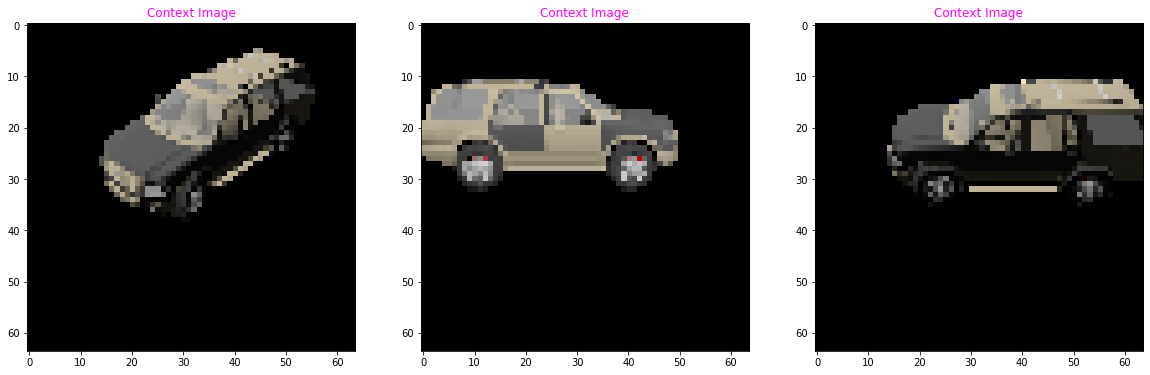

In [103]:
M = 3

# Load data
x_data, v_data, metadata = next(iter(train_loader))

x, v, x_q, v_q, context_idx, query_idx = sample_batch(x_data, v_data, D="Shepard-Metzler", M = M)

# Visualise context and query images
f, axarr = plt.subplots(1, M, figsize=(20, 7))

for i, ax in enumerate(axarr.flat):
    # Move channel dimension to end
    ax.set_title("Context Image", color="magenta")
    ax.imshow(x.squeeze(0)[i])

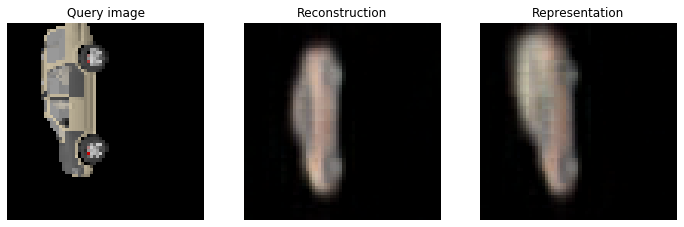

In [104]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))

x = x.permute(0,1,4,2,3).to(device)
x_q = x_q.permute(0,3,1,2).to(device)
v=v.to(device)
v_q=v_q.to(device)

model.eval()

with torch.no_grad():
    r = model.reconstruct(x, v, v_q, x_q)
    x_mu = model.generate(x, v, v_q)

    x_q = x_q.permute(0,3,2,1).cpu().detach().numpy()
    x_mu = x_mu.permute(0,3,2,1).cpu().detach().numpy()
    r = r.permute(0,3,2,1).cpu().detach().numpy()
    
x_q = x_q.squeeze(0)
x_mu = x_mu.squeeze(0)
r = r.squeeze(0)

ax1.imshow(x_q)
ax1.set_title("Query image")
ax1.axis("off")

ax2.imshow(x_mu)
ax2.set_title("Reconstruction")
ax2.axis("off")

ax3.imshow(r)
ax3.set_title("Representation")
ax3.axis("off")

plt.show()